# Tutorial - electrostatic properties

This Tutorial shows how to fit a kQEq-Model for the prediction of dipoles

In [1]:
import sys
from ase.io import read

import numpy as np
from kqeq.qeq import charge_eq
from kqeq.kernel import *
from kqeq.kQEq import kernel_qeq
from kqeq.funct import *

We start by loading a training and test set:

In [2]:
# Get data
mols_train = read("../data/QMtrainSimple.xyz@:100",format='extxyz')
mols_test = read("../data/TestQM9.xyz@:100",format='extxyz')

Next, we create instance of the kernel and descriptors. In this case, SOAP from `dscribe` package is used. `desdictSOAP` will describe hyperparameters for SOAP. Into the `SOAPKernel` class, the training set has to be included, tohether with setting full or sparse GPR. Also, with `perEl` keyword, we can choose if elements of the kernel matrix will be zero or nonzero when comparing 2 different elements. With `CURel` keyword, `sparse_count` amount of atomic environments will be selected for each element (if possible).

In [3]:
desdictSOAP = {"nmax": 3,
                    "lmax": 2,
                    "rcut": 2.8,
                    "sigma": 2.8/8,
                    "species":["O","H","N","F","C"],
                    "periodic": False}
  
SOAP_Kernel = SOAPKernel(multi_SOAP=False,
                descriptor_dict=desdictSOAP,
                training_set=mols_train,
                sparse=True,
                perEl = True,
                sparse_method = "CURel",
                sparse_count=500)

Now, the instance of `kQEq` will be created. `kernel_qeq` should be used in the case, when training is going to be done. In the case that model is already pretrained, `kQEq` class should be used. (See examples folder for more details). `scale_atsize` is a global parameter that multply sizes of atoms. Radius of atom is taken from QEq paper (`qeq` keyword), or from `ase` (`rcov`). Howver, we recomend to stick with `qeq` radii.  

In [4]:
# Set up and initialize a kqeq model with the training set and the choosen kernel
 
my_kqeq = kernel_qeq(Kernel=SOAP_Kernel,
                scale_atsize=1/np.sqrt(2.0),
                radius_type="qeq")

Now we train the model on dipole moments of the training set. 

But as a side note:
`train` function contains currently 2 `targets`; charges and dipoles. Since multiple partial charges models exist, used charges can be extracted from the extended xyz file can via `charge_keyword`. For dipole training, system dipoles have to be in extended xyz file included as `dipole_vector` info. Furthermore, different weights can be put on different targets via `target_lambdas`. Both input values should be in lists, but if only one target is selected, `targets` can be a string and `target_weights` a float. (Mixed target is commented in the following cell).

In [5]:
# Train a model with a given regularization parameter on dipoles
# my_kqeq.train(target_lambdas =[0.1], 
       # targets = ["dipole"])

# Train a model with a given regularization parameter on dipoles AND mulliken charges
my_kqeq.train(targets=["dipole","charges"],
              target_lambdas=[1.0,0.1],
              charge_keyword="mulliken")


In [6]:


# Predict dipole moments for training and validation set
dipoles_test, charges_test, enegs_test = my_kqeq.predict(mols_test)
dipoles_train, charges_train, enegs_train = my_kqeq.predict(mols_train)

# Get reference values from atoms objects
dipoles_test_ref = get_dipoles(mols_test)
dipoles_train_ref = get_dipoles(mols_train)

# Get reference values from atoms objects
charges_test_ref = get_charges(mols_test,charge_keyword = "mulliken")
charges_train_ref = get_charges(mols_train,charge_keyword = "mulliken")

In [7]:
# Plot the results
plt.scatter(dipoles_train_ref,dipoles_train, alpha = 0.6)
plt.scatter(dipoles_test_ref,dipoles_test, alpha = 0.6)
plt.plot(dipoles_train_ref,dipoles_train_ref, color="black")
plt.xlabel('Reference Dipole Vector Elements',fontsize=14)
plt.ylabel('kQEq Dipole Vector Elements',fontsize=14)
plt.show()


In [8]:
# Plot the results
plt.scatter(charges_train_ref,charges_train, alpha = 0.6)
plt.scatter(charges_test_ref,charges_test, alpha = 0.6)
plt.plot(charges_train_ref,charges_train_ref, color="black")
plt.xlabel('Mulliken charges',fontsize=14)
plt.ylabel('kQEq Charges',fontsize=14)
plt.show()


Note that there are two ways to run a kQEq model on a new system, namely `.predict` and `.calculate`. The former is for batch applications (e.g. on the full validation set), the latter for predictions on single system (as in the corresponding ase calculator). Dipole moments are always returned in atomic units. You may want to convert them to the more common Debye scale.

In [9]:
# Calculate vs. Predict:
dipoles_v, charges_v, enegs_v = my_kqeq.predict([mols_test[4]])
results                       = my_kqeq.calculate(mols_test[4])
print(dipoles_v)
print(results['dipole_vector'])

[-0.4051149  -0.43824236  0.41248705]
[-0.43858897 -0.56065837  0.44280843]


Here we shows prediction for charged molecules. The process is the same as for neutral molecules, only `training_system_charges` needs to be set up to the array of charges of the systems. The sam apply for `predict_system_charges` in prediction function. 


In [10]:
mols_plus = read("../data/PlusSet.xyz@:",format='extxyz')
print(len(mols_plus))
plus_train = mols_plus[:80]
plus_test = mols_plus[80:]
charges_plus_train = [1 for _ in plus_train]
charges_plus_test = [1 for _ in plus_test]

100


In [11]:
SOAP_Kernel = SOAPKernel(multi_SOAP=False,
                descriptor_dict=desdictSOAP,
                training_set=plus_train,
                training_system_charges=charges_plus_train,
                sparse=True,
                perEl = True,
                sparse_method = "CURel",
                sparse_count=500)

In [12]:
my_kqeq_charge = kernel_qeq(Kernel=SOAP_Kernel,
                scale_atsize=1/np.sqrt(2.0),
                radius_type="qeq")

In [13]:

# Train a model with a given regularization parameter on dipoles AND mulliken charges
my_kqeq_charge.train(targets=["dipole","charges"],
              target_lambdas=[1.0,0.1],
              charge_keyword="mulliken")

Sum of charges of the testing set: 20.000000000000004


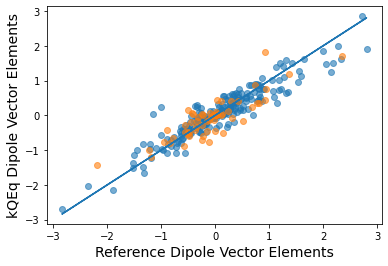

In [14]:
dipoles_train, charges_train, enegs_train = my_kqeq_charge.predict(plus_train,predict_system_charges=charges_plus_train)
dipoles_plus, charges_plus, enegs_plus = my_kqeq_charge.predict(plus_test,predict_system_charges=charges_plus_test)
print("Sum of charges of the testing set:", np.sum(charges_plus))
# Get reference values from atoms objects
dipoles_train_ref = get_dipoles(plus_train)
dipoles_plus_ref = get_dipoles(plus_test)
charges_train_ref = get_charges(plus_train,charge_keyword="mulliken")
charges_plus_ref = get_charges(plus_test,charge_keyword="mulliken")

plt.scatter(dipoles_train_ref,dipoles_train, alpha = 0.6)
plt.scatter(dipoles_plus_ref,dipoles_plus, alpha = 0.6)
plt.plot(dipoles_train_ref,dipoles_train_ref)
plt.xlabel('Reference Dipole Vector Elements',fontsize=14)
plt.ylabel('kQEq Dipole Vector Elements',fontsize=14)
plt.show()

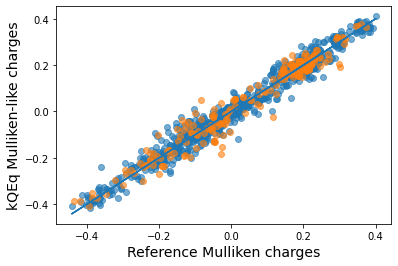

In [15]:

plt.scatter(charges_train_ref,charges_train, alpha = 0.6)
plt.scatter(charges_plus_ref,charges_plus, alpha = 0.6)
plt.plot(charges_train_ref,charges_train_ref)
plt.xlabel('Reference Mulliken charges',fontsize=14)
plt.ylabel('kQEq Mulliken-like charges',fontsize=14)
plt.show()